In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib as plt 
import markov_clustering as mc
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
from scipy.stats import describe
from collections import Counter

In [2]:
def count_by(df,var):
    nb = df.groupby([var],group_keys=False).size()
    nb = pd.DataFrame({var:nb.index,'nb_'+var:nb.values})
    nb = pd.merge(df,nb,on=var,how='left')
    return nb

In [3]:
tree = pd.read_csv("../bases/fap_pcs_rome.csv")
tree.columns = 'fap','fap_lab','pcs','pcs_lab','rome','qual','rome_lab'
tree = tree.filter(items=['fap','fap_lab','rome','rome_lab'])
tree['fap']= tree['fap'].fillna(method='ffill')
tree['fap_lab']= tree['fap_lab'].fillna(method='ffill')
tree = tree.dropna(subset=['rome'],axis=0)
tree = count_by(tree,'rome')
arbo = tree.filter(['rome','rome_lab'])
arbo = arbo.drop_duplicates('rome')

In [2]:
%run rome.py
romes = list(graph.keys())

In [23]:
connections = {'rome':list(graph.keys()),'connections':[len(connex) for connex in graph.values()]}
pd.DataFrame(connections).to_csv('../results/connections.csv',index=False)

In [5]:
data = pd.read_csv("../bases/rome_tension.csv")

In [6]:
data = data[['rome5','BE_id','T']]

In [7]:
len(data.BE_id.unique())

411

In [8]:
data = data.pivot(index='BE_id',columns='rome5',values='T')

In [9]:
data = data.sub(data.mean(axis=1),axis=0)

Define undirected graph

In [10]:
EG = nx.Graph()
EG.add_nodes_from(romes)
weights = {}
edge, noedge = 0, 0
for rome1 in romes:
    weights[rome1] = {}
    s = 0
    for rome2 in graph[rome1]:
        corr = np.exp(data[rome1].corr(data[rome2]))
        weights[rome1][rome2] = corr
        s += weights[rome1][rome2]
    for rome2 in weights[rome1].keys():
        weights[rome1][rome2] =  weights[rome1][rome2]/s

for rome1 in romes:
    current_edges = list(EG.edges)
    for rome2 in weights[rome1].keys():
        if rome1 not in weights[rome2].keys(): w = weights[rome1][rome2]/2
        if rome1 in weights[rome2].keys(): w = (weights[rome1][rome2]+weights[rome2][rome1])/2
        if (rome2,rome1) not in current_edges:
                EG.add_edge(rome1,rome2,weight=w)
                
matrix = nx.adjacency_matrix(EG)

**Run MCL algorithm for different inflation parameters:** 

In [13]:
inflations = [round(1.36 + i/1000,ndigits=3) for i in range(10)]
results = {'clusters':{},
           'lonely':{},
           'mean_size':{},
           'median_size':{},
           'max_size':{},
           'var_size':{},
           'average_within':{},
           'average_shortest_path':{}}
clustered_romes = pd.DataFrame()
clustered_romes['rome'] = romes
store_CL = {}
for inf in inflations:
    result = mc.run_mcl(matrix,inflation=inf)
    clusters = mc.get_clusters(result)
    CL = [[romes[x] for x in c] for c in clusters]
    store_CL[inf] = CL 
    results['clusters'][inf] = len(CL)
    results['lonely'][inf] = sum([len(cl) == 1 for cl in CL])
    results['mean_size'][inf] = np.mean([len(c) for c in CL])
    results['median_size'][inf] = np.median([len(c) for c in CL])
    results['max_size'][inf] = np.max([len(c) for c in CL])
    results['var_size'][inf] = np.var([len(c) for c in CL])
    results['average_within'][inf] = 0
    results['average_shortest_path'][inf] = 0
    
    clusters = []
    groups = []
    shortest = []
    
    s = 0
    for i, clus in enumerate(CL):
        clusters += clus
        groups += [i+1]*len(clus)
        s += len(clus)
        results['average_within'][inf] += data.filter(clus).mean().values.var()/(results['clusters'][inf]-results['lonely'][inf])
        n = 0
        p = 0
        for c in combinations(clus,2):
            p += nx.shortest_path_length(EG,c[0],c[1])
            n += 1
        if n > 0: 
            shortest +=  [p/n]*len(clus)
            results['average_shortest_path'][inf] += (p/n)*len(clus)/len(romes)
        else : shortest +=  [0]*len(clus)
    tmp = pd.DataFrame()
    tmp['rome'] = clusters
    tmp[f'group_{inf}'] = groups
    tmp[f'shortest_{inf}'] = shortest
    tmp = tmp.sort_values('rome')
    clustered_romes = pd.merge(clustered_romes,tmp,on='rome',how='right')
    for key in ['mean_size','median_size','average_shortest_path','max_size']:
        results[key][inf] = round(results[key][inf],ndigits=1)
    results['average_within'][inf] = round(results['average_within'][inf],ndigits = 4)
    results['lonely'][inf] = results['lonely'][inf]/results['clusters'][inf]
    

In [15]:
pd.DataFrame(results).to_latex('../results/mcl_results_exp_fe.tex')

ADD LABELS

In [16]:
clustered_romes = pd.merge(clustered_romes,arbo,on='rome',how='left')
clustered_romes.loc[clustered_romes.rome == 'L1510','rome_lab'] = "Films d'animation et effets spéciaux"

SAVE RESULTS 

In [17]:
for i in inflations: 
    tmp = clustered_romes.filter(['rome',f'group_{i}',f'shortest_{i}','rome_lab'])
    tmp.columns = 'rome', 'group','shortest','rome_lab'
    tmp = tmp.sort_values('group').reset_index(drop=True)
    tmp = tmp.filter(['rome','group','rome_lab','shortest'])
    index = str(i)
    index = index.replace('.','_')
    tmp.to_csv(f'../results/clustered_romes_{index}_exp_fe.csv',index=False)

**SELECT SPECIFICATION AND COMPUTE CONNEX GROUPS**
(Select inflation parameter 1.362 to have 100 groups). 

In [3]:
clustered_romes = pd.read_csv('../results/clustered_romes_1_362_exp_fe.csv')
clusters = clustered_romes.group.unique().tolist()
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(clustered_romes)

      rome  group                                           rome_lab  shortest
0    E1106      1                   Journalisme et information média  1.800000
1    E1108      1                         Traduction, interprétariat  1.800000
2    E1103      1                                      Communication  1.800000
3    E1401      1            Développement et promotion publicitaire  1.800000
4    E1107      1                        Organisation d'événementiel  1.800000
5    L1304      2     Réalisation cinématographique et audiovisuelle  2.942857
6    E1205      2                Réalisation de contenus multimédias  2.942857
7    L1301      2                Mise en scène de spectacles vivants  2.942857
8    M1806      2  Expertise et support technique en systèmes d'i...  2.942857
9    H1204      2                                  Design industriel  2.942857
10   M1810      2  Production et exploitation de systèmes d'infor...  2.942857
11   M1801      2           Administration de systèm

Purge origina graph from within group connexions: 

In [5]:
purged_graph = {}
for rome, romes in graph.items():
    g = clustered_romes.loc[clustered_romes.rome == rome,'group'].values.tolist()[0]
    group = clustered_romes.loc[clustered_romes.group == g,'rome'].values.tolist()
    purged_graph[rome] = [x for x in romes if x not in group]

Compute the 1/(herfindal of connexions) by group: (DIVIDE BY SIZE OF EACH GROUP BEFORE COMPUTING SHARES) 

In [8]:
herfs = {}
shares = {}
groups = cluster_groups.keys()
for i,group in cluster_groups.items():
    shares[i] = {}
    for j in groups:
        l = len(cluster_groups[j])
        shares[i][j] = 0 
        for rome1 in group:
            shares[i][j] += sum([rome2 in cluster_groups[j] for rome2 in purged_graph[rome1]])/l
    tot = sum(shares[i].values())
    if tot > 0:
        shares[i] = {j:(v/tot) for j,v in shares[i].items()}
        herfs[i] = int(round(1/sum([v**2 for v in shares[i].values()])))
    else: 
        herfs[i] = 0
shares = {i:{j:s for j,s in shares[i].items() if s > 0} for i in shares.keys()} 
shares = {i:dict(sorted(shares[i].items(),key=lambda x: x[1],reverse=True)) for i in shares.keys()}

{1: {48: 0.5391527599486522,
  98: 0.1797175866495507,
  57: 0.13478818998716305,
  12: 0.10783055198973043,
  5: 0.038510911424903725},
 2: {40: 0.18741633199464522,
  42: 0.12494422132976347,
  3: 0.09370816599732261,
  92: 0.09370816599732261,
  1: 0.0749665327978581,
  8: 0.0749665327978581,
  89: 0.0749665327978581,
  90: 0.0749665327978581,
  4: 0.06247211066488174,
  5: 0.05354752342704149,
  32: 0.046854082998661305,
  12: 0.03748326639892905},
 3: {1: 1.0},
 4: {47: 0.4106910039113429,
  91: 0.18252933507170796,
  63: 0.10951760104302478,
  20: 0.09126466753585398,
  74: 0.09126466753585398,
  36: 0.07822685788787484,
  24: 0.03650586701434159},
 5: {32: 0.14723843126611483,
  78: 0.13087860556987985,
  68: 0.09815895417740989,
  71: 0.09815895417740989,
  79: 0.09815895417740989,
  92: 0.09815895417740989,
  74: 0.06543930278493992,
  80: 0.06543930278493992,
  64: 0.05609083095851993,
  19: 0.050662686027050256,
  12: 0.03926358167096396,
  2: 0.026175721113975967,
  24: 0.0

Prepare data for correlations

In [10]:
data = pd.read_csv("../bases/rome_tension.csv")
data = data[['rome5','BE_id','T']]
data_means = data.groupby('BE_id').mean()
data_means['BE_id'] = data_means.index
data_means = data_means.reset_index(drop=True).rename(columns = {'T':'mean'})
data=pd.merge(data,data_means,how='left',on='BE_id')
data['T'] = data['T'] - data['mean']
data = data[['rome5','BE_id','T']].rename(columns = {'rome5':'rome'})
data = pd.merge(data,clustered_romes,on='rome',how='left')
data = data.groupby(['group','BE_id']).mean().reset_index(level=['BE_id','group'])
data.BE_id = data.BE_id.astype(str)
data = data.pivot(index='BE_id',columns='group',values='T')

In [11]:
clustered_graph = {}
for i,group in cluster_groups.items(): 
    clustered_graph[i] = []
    for rome in group:
        clustered_graph[i] += [j for j, clus in cluster_groups.items() if list(set(clus) & set(graph[rome])) != [] and j != i ]
    clustered_graph[i] = list(set(clustered_graph[i]))

In [12]:
clustered_graph_length = {i:len(v) for i,v in clustered_graph.items()}
ok = {i: clustered_graph_length[i] >= v for i,v in herfs.items()}
all(ok.values())

True

In [13]:
clustered_graph_ordered = {}
clustered_graph_trimmed = {}
correlations = {}
for i,connex in clustered_graph.items():
    correlations[i] = {}
    for j in connex: 
        correlations[i][j] = data[i].corr(data[j])
    correlations[i] = dict(sorted(correlations[i].items(),key=lambda x: x[1],reverse=True))
    clustered_graph_ordered[i] = list(correlations[i].keys())
    clustered_graph_trimmed[i] = clustered_graph_ordered[i][0:herfs[i]]

In [14]:
clustered_graph_export = {'group':[],'connex':[],'share':[],'herfs':[],'corr':[]}
for i, groups in shares.items():
    l = len(groups)
    clustered_graph_export['group'] += [i]*(1+l)
    clustered_graph_export['connex'] += [i] + list(groups.keys())
    clustered_graph_export['share'] += ['.'] + list(groups.values())
    clustered_graph_export['herfs'] += [herfs[i]]*(1+l)
    clustered_graph_export['corr'] += ['.'] + [correlations[i][j] for j in groups.keys()]

In [15]:
pd.DataFrame(clustered_graph_export).to_csv('../results/connex_clusters.csv',index=False)

Compute the groups j from which i can receive DE:

In [64]:
from_group = {}
for j in clustered_graph_trimmed.keys():
    from_group[j] = []
    for i, connex in clustered_graph_trimmed.items():
        if len(connex) > 0:
            if j == connex[0]:
                from_group[j].append(i)

In [66]:
graph_lengths = Counter([len(connex) for connex in graph.values()])
purged_graph_lengths = Counter([len(connex) for connex in purged_graph.values()])
clustered_graph_lengths = Counter([len(connex) for connex in clustered_graph.values()])
clustered_graph_trimmed_lengths = Counter([len(connex) for connex in clustered_graph_trimmed.values()])

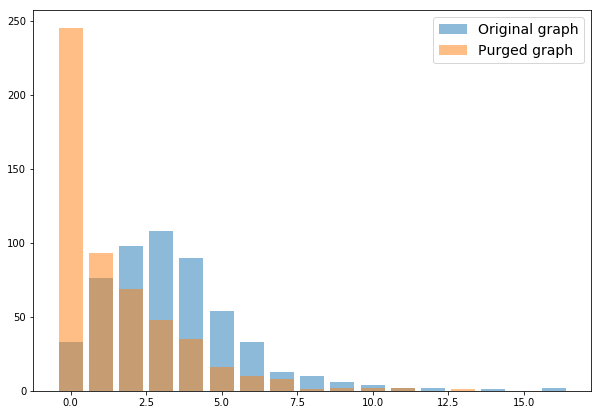

In [67]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(graph_lengths.keys(),graph_lengths.values(),alpha=0.5)
axs.bar(purged_graph_lengths.keys(),purged_graph_lengths.values(),alpha=0.5)
axs.legend(['Original graph','Purged graph'],prop={'size':14})
fig.savefig('../results/connex_romes.png')

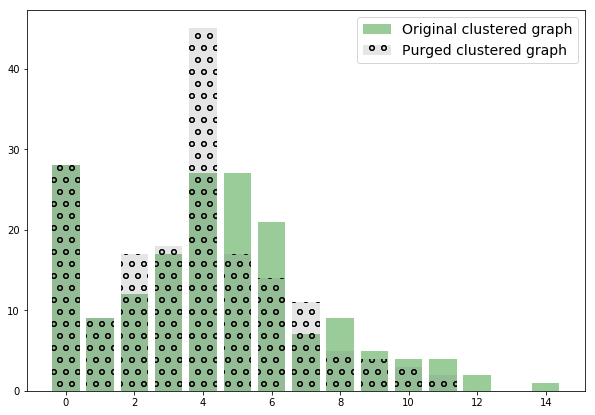

In [395]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(clustered_graph_lengths.keys(),clustered_graph_lengths.values(),color='g',alpha=0.4)
axs.bar(clustered_graph_trimmed_lengths.keys(),clustered_graph_trimmed_lengths.values(),color='0.5',alpha=0.2,ecolor='black',hatch='o')
axs.legend(['Original clustered graph','Purged clustered graph'],prop={'size':14})
fig.savefig('../results/connex_clusters.png')

In [398]:
clustered_romes = pd.read_csv('../results/clustered_romes_2_1_no_weights.csv')
clusters = clustered_romes.group.unique().tolist()
print(len(clusters))
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}
cluster_size_no_weight = Counter([len(group) for group in cluster_groups.values()])

clustered_romes = pd.read_csv('../results/clustered_romes_1_3_fe.csv')
clusters = clustered_romes.group.unique().tolist()
print(len(clusters))
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}
cluster_size_fe = Counter([len(group) for group in cluster_groups.values()])

clustered_romes = pd.read_csv('../results/clustered_romes_1_5_exp_fe.csv')
clusters = clustered_romes.group.unique().tolist()
print(len(clusters))
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}
cluster_size_exp_fe = Counter([len(group) for group in cluster_groups.values()])

143
153
173


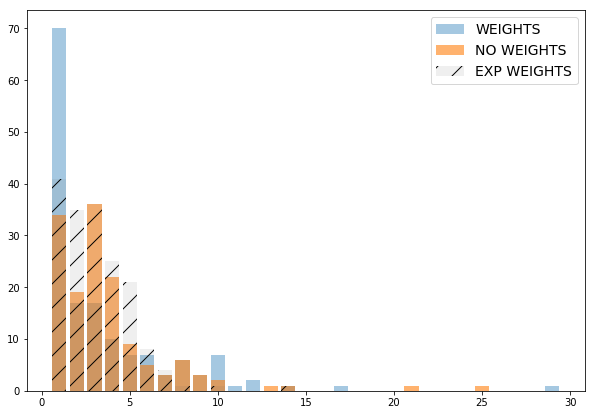

In [422]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(cluster_size_fe.keys(),cluster_size_fe.values(),alpha=0.4)
axs.bar(cluster_size_no_weight.keys(),cluster_size_no_weight.values(),alpha=0.6,)
axs.bar(cluster_size_exp_fe.keys(),cluster_size_exp_fe.values(),color='0.4',hatch='/',alpha=0.1)
axs.legend(['WEIGHTS','NO WEIGHTS','EXP WEIGHTS'],prop={'size':14})
fig.savefig('../results/cluster_sizes.png')